# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

---

## Zestaw zadań 10: Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL (część 4)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import libpysal as ps
import pointpats as pp

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów

In [3]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań
def point_count_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca liczbą punktów przypisanych do każdego z podobszarów.
    """
    counts = [np.sum(points.within(subregion)) for subregion in subregions['geometry']]
    return pd.Series(counts)
    
def intensity_on_subregions(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    counts: Series
        Seria Pandas zawierająca intensywność przypisaną do każdego z podobszarów.
    """
    return point_count_on_subregions(points, subregions)/subregions.area

#### UWAGA!
Znaczna część przykładów i dokumentacji modułów wchodzących w skład pakietu pysal dostępna w internecie nie dotyczny ich najnowszych wersji.
Z tego powodu lepiej jest zdobywać informacje na temat wykorzystywanych modułów, klas i funkcji z wykorzystaniem funkcji help(), np.: help(ps), help(pp), help(pp.pointpattern).

### Import i przygotowanie danych
Wykorzystując funkcję `geopandas.read_file()` zaimportuj do notatnika dane z dołączonych do niego plików (zakres importowanych danych i odwzorowanie kartograficzne nie wymagają zmian).

In [4]:
pts1 = gpd.read_file("points_1.zip")
pts2 = gpd.read_file("points_2.zip")
powiaty = gpd.read_file("Powiaty.zip")

### Zadanie 1: Autokorelacja przestrzenna danych (25 pkt)

Przygotuj funkcję `spatial_autocorelation_data()`, która będzie przygotowywać dane niezbędne do oceny autokorelacji przestrzennej analizowanych danych.

Schemat postępowania:
- zagreguj dane na obszarze poszczegolnych powiatów (ze względu na różnice w powierzchni obszarów skorzystaj z wyliczonych dla nich wartości intensywności, a nie samej liczby zliczeń w ich obrębie),
- wyznacz macierz wag przestrzennych,
- wylicz opóźnienie przestrzenne,
- przygotuj dane niezbędne do wykonania wykresu Morana.

Następnie wykorzystaj przygotowane funkcje do oceny autokorelacji przestrzennej rozkładów punktów z plików points_2.zip i points_3.zip.
Przedstaw wyniki analizy graficznie w postaci kartogramów intensywności i opóźnienia przestrzennego z nałożonymi na nie rozkładami punktów oraz za pomocą wykresów Morana. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x3).

Przydatne klasy i funkcje:
- `libpysal.weights.Queen()`
- `libpysal.weights.Rook()`
- `libpysal.weights.spatial_lag.lag_spatial()`

#### a) Przygotowanie funkcji

In [5]:
def spatial_autocorelation_data(points, subregions):
    """
    Parameters
    -------
    points: GeoSeries
        Tablica zawierająca punkty zapisane jako obiekty shapely.geometry.point.Point.
    subregions: GeoDataFrame
        Tablica zawierająca geometrie podobszarów zapisane jako obiekty shapely.geometry.polygon.Polygon.
    Returns
    -------
    moran_plot_data: GeoDataFrame
        Obiekt GeoDataFrame zawierający następujące kolumny:
        "geometry" - kolumna z geometrią podobszarów,
        "intensity" - wartości intesywności procesu w obrębie poszczególnych podobszarów,
        "lag" - wartości opóźnienia przestrzennego w obrębie poszczególnych podobszarów,
        "intensity_std" - ustandaryzowane wartości intensywności.
        "lag_std" - ustandaryzowane wartości opóźnienia przestrzennego.
    """
    moran_plot_data = gpd.GeoDataFrame(subregions.geometry, crs = subregions.crs)
    moran_plot_data["intensity"] = intensity_on_subregions(points, subregions)
    neighbours = ps.weights.Rook.from_dataframe(powiaty)
    moran_plot_data["lag"] = ps.weights.spatial_lag.lag_spatial(neighbours, moran_plot_data["intensity"])
    moran_plot_data["intensity_std"] = moran_plot_data["intensity"] - moran_plot_data["intensity"].mean()
    moran_plot_data["lag_std"] = moran_plot_data["lag"] - moran_plot_data["lag"].mean()
    return moran_plot_data

#### b) Wygenerowanie danych

In [6]:
autocorr1 = spatial_autocorelation_data(pts1, powiaty)
autocorr2 = spatial_autocorelation_data(pts2, powiaty)

#### c) Wizualizacja

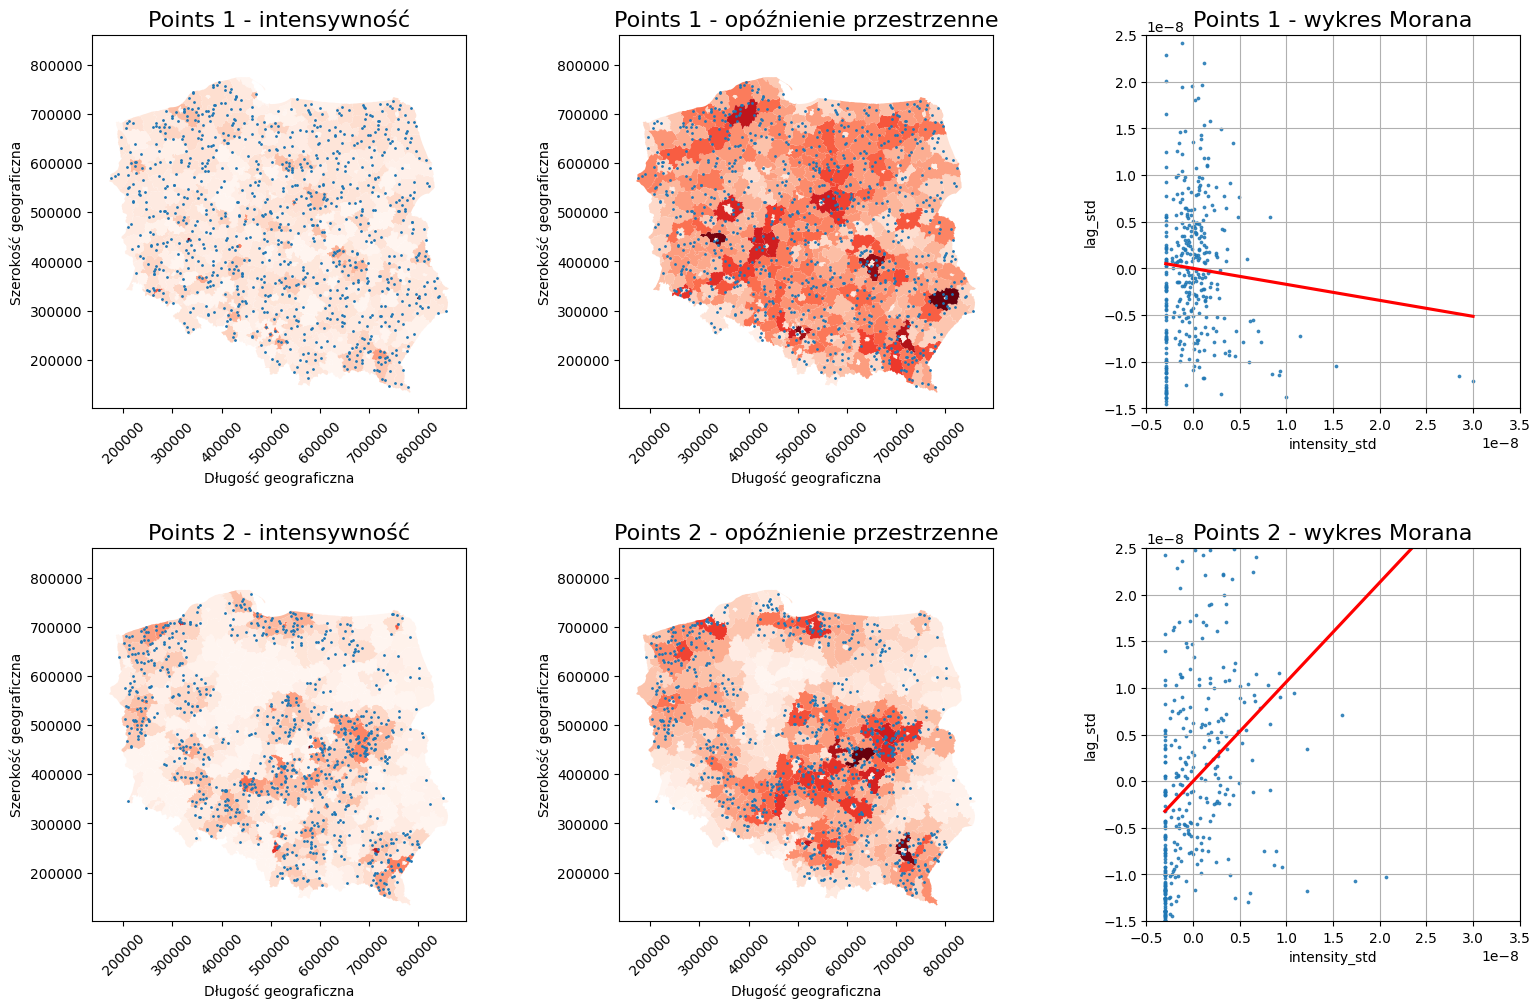

In [7]:
fig, axes = plt.subplots(2, 3, figsize = (15,10))
fig.tight_layout(h_pad = 4, w_pad = 8)

autocorr1.plot(ax = axes[0][0], column="intensity", cmap='Reds')
pts1.plot(ax = axes[0][0], markersize = 1)
axes[0][0].axis('square')
axes[0][0].tick_params(axis = 'x', labelrotation = 45)
axes[0][0].set_xlabel("Długość geograficzna")   
axes[0][0].set_ylabel("Szerokość geograficzna")
axes[0][0].set_title("Points 1 - intensywność", fontsize = 16);

autocorr1.plot(ax = axes[0][1], column="lag", cmap='Reds')
pts1.plot(ax = axes[0][1], markersize = 1)
axes[0][1].axis('square')
axes[0][1].tick_params(axis = 'x', labelrotation = 45)
axes[0][1].set_xlabel("Długość geograficzna")   
axes[0][1].set_ylabel("Szerokość geograficzna")
axes[0][1].set_title("Points 1 - opóźnienie przestrzenne", fontsize = 16);

sns.regplot(data = autocorr1, x = "intensity_std", y = "lag_std", ax = axes[0][2],
            ci = None, line_kws = {"color" : "red"}, scatter_kws={'s':3})
axes[0][2].set_title("Points 1 - wykres Morana", fontsize = 16)
axes[0][2].grid()
axes[0][2].axis('square')
axes[0][2].set_xlim([-0.5e-8, 3.5e-8])
axes[0][2].set_ylim([-1.5e-8, 2.5e-8])

autocorr2.plot(ax = axes[1][0], column="intensity", cmap='Reds')
pts2.plot(ax = axes[1][0], markersize = 1)
axes[1][0].axis('square')
axes[1][0].tick_params(axis = 'x', labelrotation = 45)
axes[1][0].set_xlabel("Długość geograficzna")   
axes[1][0].set_ylabel("Szerokość geograficzna")
axes[1][0].set_title("Points 2 - intensywność", fontsize = 16); 

autocorr2.plot(ax = axes[1][1], column="lag", cmap='Reds')
pts2.plot(ax = axes[1][1], markersize = 1)
axes[1][1].axis('square')
axes[1][1].tick_params(axis = 'x', labelrotation = 45)
axes[1][1].set_xlabel("Długość geograficzna")   
axes[1][1].set_ylabel("Szerokość geograficzna")
axes[1][1].set_title("Points 2 - opóźnienie przestrzenne", fontsize = 16);

sns.regplot(data = autocorr2, x = "intensity_std", y = "lag_std", ax = axes[1][2], 
            ci = None, line_kws = {"color" : "red"}, scatter_kws={'s':3})
axes[1][2].set_title("Points 2 - wykres Morana", fontsize = 16)
axes[1][2].grid()
axes[1][2].axis('square')
axes[1][2].set_xlim([-0.5e-8, 3.5e-8])
axes[1][2].set_ylim([-1.5e-8, 2.5e-8]);